In [6]:
import sys
import os
from os.path import join
PROJECT_ROOT = os.path.abspath(os.path.join(os.path.dirname("__file__"), ".."))
sys.path.append(PROJECT_ROOT)
from src.utils.preprocessing import preprocess_pipeline
from os.path import join
from src.data.mnist_loader import MnistDataloader
from src.evaluation.evaluation import evaluate_model
from src.models.cnn import MNISTCNN
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

input_path = "../data"

mnist = MnistDataloader(
    join(input_path, "train-images-idx3-ubyte/train-images-idx3-ubyte"),
    join(input_path, "train-labels-idx1-ubyte/train-labels-idx1-ubyte"),
    join(input_path, "t10k-images-idx3-ubyte/t10k-images-idx3-ubyte"),
    join(input_path, "t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte"),
)

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Training data (with augmentation)
x_train_prep, y_train_prep = preprocess_pipeline(
    x_train, y_train, augment=True
)

# Test data (no augmentation)
x_test_prep, y_test_prep = preprocess_pipeline(
    x_test, y_test, augment=False
)

In [7]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert test data to tensors
x_test_tensor = torch.tensor(x_test_prep, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_prep, dtype=torch.long)

# Create DataLoader
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [11]:
# Load the trained model
model = MNISTCNN()
model.load_state_dict(torch.load("../models/mnist_cnn.pth"))
model.eval()  # Set the model to evaluation mode


MNISTCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [12]:
# Evaluate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results = evaluate_model(model, test_loader, device)

print("Test accuracy:", results["accuracy"])


Test accuracy: 0.9938


In [13]:
print("Test scores:", results["classification_report"])

Test scores: {'0': {'precision': 0.9989754098360656, 'recall': 0.9948979591836735, 'f1-score': 0.9969325153374233, 'support': 980.0}, '1': {'precision': 0.9956063268892794, 'recall': 0.9982378854625551, 'f1-score': 0.9969203695556533, 'support': 1135.0}, '2': {'precision': 0.9913294797687862, 'recall': 0.997093023255814, 'f1-score': 0.9942028985507246, 'support': 1032.0}, '3': {'precision': 0.9921182266009853, 'recall': 0.997029702970297, 'f1-score': 0.994567901234568, 'support': 1010.0}, '4': {'precision': 0.9918864097363083, 'recall': 0.9959266802443992, 'f1-score': 0.9939024390243902, 'support': 982.0}, '5': {'precision': 0.9855233853006682, 'recall': 0.992152466367713, 'f1-score': 0.9888268156424581, 'support': 892.0}, '6': {'precision': 0.9947643979057592, 'recall': 0.9916492693110647, 'f1-score': 0.9932043910088866, 'support': 958.0}, '7': {'precision': 0.9931972789115646, 'recall': 0.9941634241245136, 'f1-score': 0.9936801166747691, 'support': 1028.0}, '8': {'precision': 0.99896

In [14]:
df = pd.DataFrame(results["classification_report"]).T


df = df.drop(columns=["support"])


df = df.round(4)

print(df)

              precision  recall  f1-score
0                0.9990  0.9949    0.9969
1                0.9956  0.9982    0.9969
2                0.9913  0.9971    0.9942
3                0.9921  0.9970    0.9946
4                0.9919  0.9959    0.9939
5                0.9855  0.9922    0.9888
6                0.9948  0.9916    0.9932
7                0.9932  0.9942    0.9937
8                0.9990  0.9908    0.9948
9                0.9950  0.9851    0.9900
accuracy         0.9938  0.9938    0.9938
macro avg        0.9937  0.9937    0.9937
weighted avg     0.9938  0.9938    0.9938


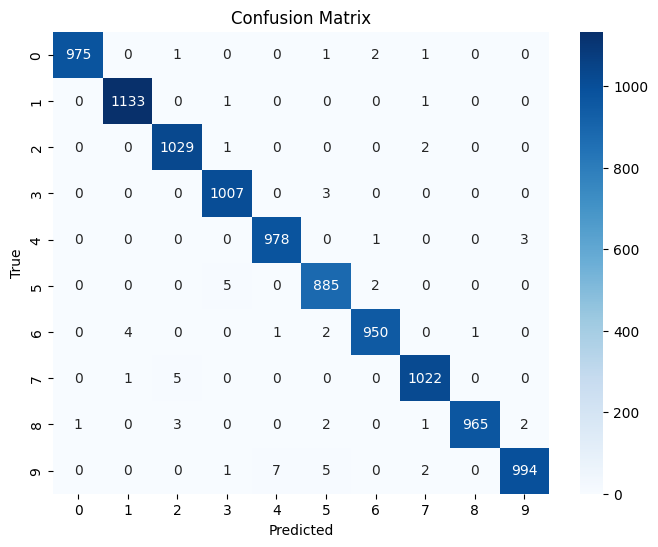

In [15]:
# Plot confusion matrix
cm = results["confusion_matrix"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Identify misclassified examples

preds = results["predictions"]
labels = results["labels"]

mis_idx = np.where(preds != labels)[0]


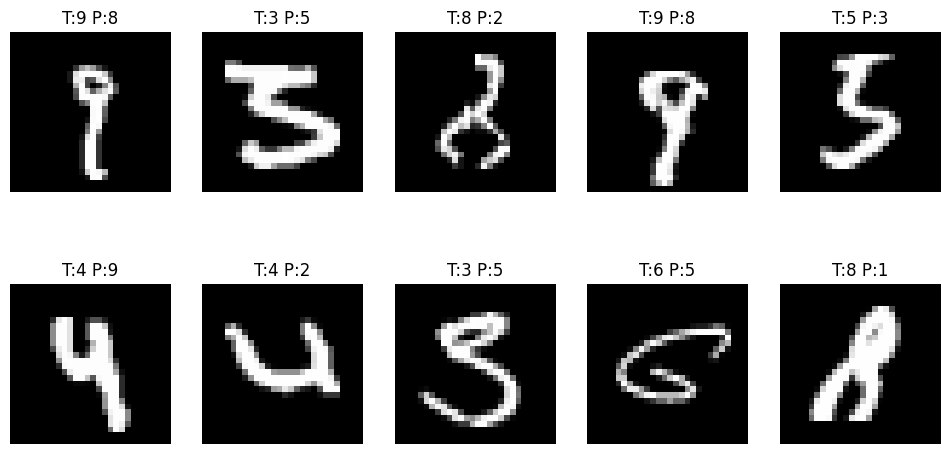

In [8]:
# Visualize misclassified images
plt.figure(figsize=(12, 6))
for i, idx in enumerate(mis_idx[:10]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_test_prep[idx].squeeze(), cmap="gray")
    plt.title(f"T:{labels[idx]} P:{preds[idx]}")
    plt.axis("off")
plt.show()
